In [435]:
import math
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

In [436]:
data = pd.DataFrame()

data["strikes"] = [95, 96, 97, 98, 99, 100, 101, 102, 103, 104]
data["prices"] = [10.93, 9.55, 8.28, 7.4, 6.86, 6.58, 6.52, 6.49, 6.47, 6.46]

In [437]:
r = 0
t = 0
S = 100
sigma = 0.2
T=1

def calculate_d1_d2(data, r, sigma):
    data['d1'] = (np.log(S / data["strikes"]) + (r + (sigma**2) / 2) * 1) / (sigma * np.sqrt(1))
    data['d2'] = data['d1'] - sigma * np.sqrt(1)
    
def calculate_call_price(data, r):
    data['black_scholes_price'] = S * norm.cdf(data['d1']) - data["strikes"] * np.exp(-r * 1) * norm.cdf(data['d2'])  
    
calculate_d1_d2(data, r, sigma)
calculate_call_price(data, r) #Estimation Black Scholes

In [438]:
import scipy.stats as ss
from decimal import Decimal
import math as m
import numpy as np
from datetime import date,timedelta

def call_bsm (S0,K,r,T,Otype,sig):
    d1 = (m.log(S0/K)) + (r+ (sig*sig)/2)*T/(sig*(m.sqrt(T)))
    d2 = d1 - sig*(m.sqrt(T))
    if (Otype == "Call"):
        price = S0*(ss.norm.cdf(np.float(d1))) \
        - K*(m.exp(-r*T))*(ss.norm.cdf(np.float(d2)))
        return (price)
    elif (Otype == "Put"):
        price  = -S0*(ss.norm.cdf(np.float(-d1)))\
        + K*(m.exp(-r*T))*(ss.norm.cdf(np.float(-d2)))
        return (price)

def vega (S0,K,r,T,sig):
    d1 = (m.log(S0/K))/(sig*(m.sqrt(T))) + ((r+ (sig*sig)/2)*T/(sig*(m.sqrt(T))))
    vega = S0*(ss.norm.pdf(np.float(d1)))*(m.sqrt(T))
    return(vega)
    
    
def imp_vol(S0, K, T, r, market,flag):
    e = 10e-15; x0 = (1);  
    def newtons_method(S0, K, T, r, market,flag,x0, e):
        delta = call_bsm (S0,K,r,T,flag,x0) - market
        while delta > e:
            x0 = (x0 - (call_bsm (S0,K,r,T,flag,x0) - market)/vega (S0,K,r,T,x0))
            delta = abs(call_bsm (S0,K,r,T,flag,x0) - market)
        return((x0))
    sig =  newtons_method(S0, K, T, r, market,flag,x0 , e)   
    return(sig)


In [439]:
data_test = data.copy()
data_test

,strikes,prices,d1,d2,black_scholes_price
0,95,10.93,0.356466,0.156466,10.519541
1,96,9.55,0.304110,0.104110,9.967734
2,97,8.28,0.252296,0.052296,9.436589
3,98,7.40,0.201014,0.001014,8.925975
4,99,6.86,0.150252,-0.049748,8.435711
5,100,6.58,0.100000,-0.100000,7.965567
6,101,6.52,0.050248,-0.149752,7.515268
7,102,6.49,0.000987,-0.199013,7.084494
8,103,6.47,-0.047794,-0.247794,6.672890
9,104,6.46,-0.096104,-0.296104,6.280064


In [471]:
iv = []

r = 0
t = 0
S = 100
sigma = 0.2
T=1
flag = 'Call'

for i,j in zip(data_test['strikes'],data_test['prices']):
    iv.append(imp_vol(S,i,T,r,j,'Call'))
data_test["implied_vol"] = iv

In [472]:
data_test

,strikes,prices,d1,d2,black_scholes_price,implied_vol
0,95,10.93,0.356466,0.156466,10.519541,0.214806
1,96,9.55,0.304110,0.104110,9.967734,0.191908
2,97,8.28,0.252296,0.052296,9.436589,0.171904
3,98,7.40,0.201014,0.001014,8.925975,0.161847
4,99,6.86,0.150252,-0.049748,8.435711,0.160302
5,100,6.58,0.100000,-0.100000,7.965567,0.165124
6,101,6.52,0.050248,-0.149752,7.515268,0.175224
7,102,6.49,0.000987,-0.199013,7.084494,0.185800
8,103,6.47,-0.047794,-0.247794,6.672890,0.196357
9,104,6.46,-0.096104,-0.296104,6.280064,0.206900


In [473]:
def black_scholes_call_price(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price


def newton_raphson_implied_vol(row, S, r, initial_guess=0.2, T=1):     
    sigma = initial_guess     
    K = row['strikes']  # Prix d'exercice
    price_market = row['prices']  # Prix du marché
    for _ in range(100):           
        d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        price_model = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)  # Prix calculé par le modèle
        vega = S * np.sqrt(T) * norm.pdf(d1)  # Vega
        price_diff = price_market - price_model  # Différence de prix                  
        if np.abs(price_diff) < 1e-8:               
            return sigma                  
        sigma += price_diff / vega  # Mise à jour de sigma
        if sigma < 0:               
            sigma = 0.001     
    return sigma

def quadratic_interpolation(x_interpolated, x_original, y_original):
    y_interpolated = []
    for x in x_interpolated:
        for i in range(len(x_original) - 2):
            if x_original[i] <= x <= x_original[i + 2]:
                x1, x2, x3 = x_original[i], x_original[i + 1], x_original[i + 2]
                y1, y2, y3 = y_original[i], y_original[i + 1], y_original[i + 2]
                break

        A = np.array([[x1**2, x1, 1], [x2**2, x2, 1], [x3**2, x3, 1]])
        B = np.array([y1, y2, y3])
        a, b, c = np.linalg.solve(A, B)
        y = a*x**2 + b*x + c
        y_interpolated.append(y)

    return y_interpolated

In [474]:
data["implied_vol"] = data.apply(lambda row: newton_raphson_implied_vol(row, S, r, 1), axis=1)
data["implied_vol"]

0    0.210948
1    0.189023
2    0.170031
3    0.160956
4    0.160079
5    0.165124
6    0.175031
7    0.185098
8    0.194908
9    0.204530
Name: implied_vol, dtype: float64

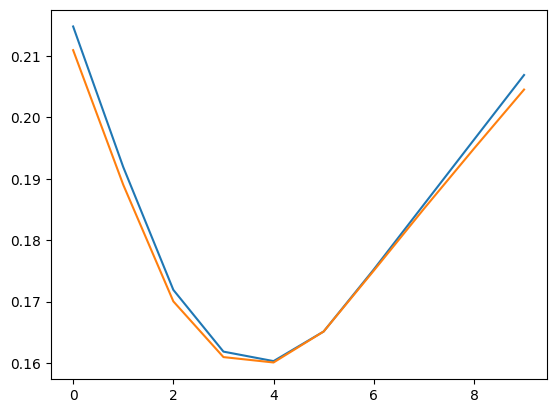

In [475]:
data_test['implied_vol'].plot()
data['implied_vol'].plot()

plt.show()

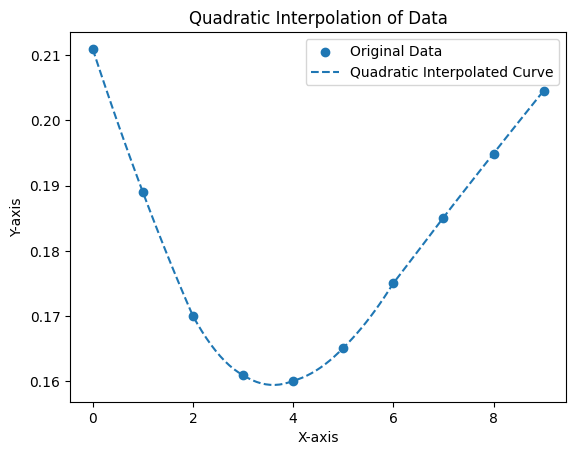

In [476]:
#quadratic interp for better smoothing of the curve

def quadratic_interpolation(x_interpolated, x_original, y_original):
    y_interpolated = []

    for x in x_interpolated:
        # Find the segment in which x falls
        for i in range(len(x_original) - 2):
            if x_original[i] <= x <= x_original[i + 2]:
                x1, x2, x3 = x_original[i], x_original[i + 1], x_original[i + 2]
                y1, y2, y3 = y_original[i], y_original[i + 1], y_original[i + 2]
                break

        # Quadratic interpolation formula
        # Solving for coefficients a, b, and c of the quadratic equation y = ax^2 + bx + c
        A = np.array([[x1**2, x1, 1], [x2**2, x2, 1], [x3**2, x3, 1]])
        B = np.array([y1, y2, y3])
        a, b, c = np.linalg.solve(A, B)

        # Calculate the interpolated y value
        y = a*x**2 + b*x + c
        y_interpolated.append(y)

    return y_interpolated

# Example data
# Replace 'data.index' and 'data["implied_vol"]' with your actual data
x_original = np.array(data.index)
y_original = np.array(data["implied_vol"])

nb_pts = 100
x_interpolated = np.linspace(x_original.min(), x_original.max(), nb_pts)
y_interpolated = quadratic_interpolation(x_interpolated, x_original, y_original)

# Plotting
plt.scatter(x_original, y_original, label='Original Data')
plt.plot(x_interpolated, y_interpolated, label='Quadratic Interpolated Curve', linestyle='--')
plt.legend()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Quadratic Interpolation of Data')
plt.show()

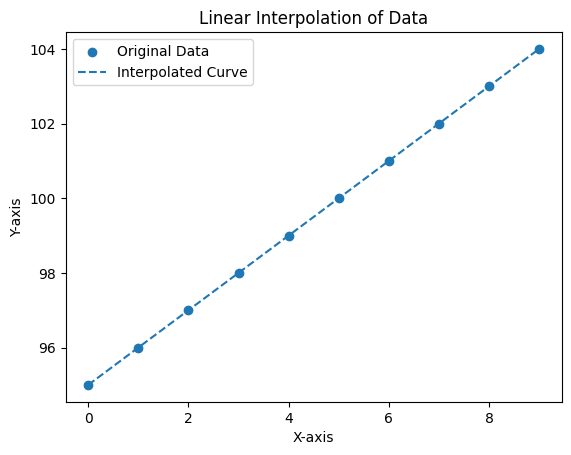

In [477]:
#interpolation of strikes

x_original=data.index
y_original=data["strikes"]
nb_pts=100
x_interpolated=np.linspace(x_original.min(), x_original.max(), nb_pts)
strike_interpolated = quadratic_interpolation(x_interpolated, x_original, y_original)

plt.scatter(x_original, y_original, label='Original Data')
plt.plot(x_interpolated, strike_interpolated, label='Interpolated Curve', linestyle='--')
plt.legend()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Linear Interpolation of Data')
plt.show()

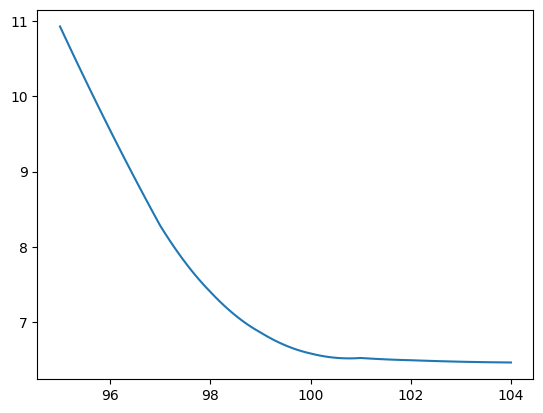

In [478]:
def black_scholes_call_price(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price


prices=[]

for i,j in zip(strike_interpolated,y_interpolated):
    prices.append(black_scholes_call_price(S,i,T,r,j))

df=pd.DataFrame([prices,strike_interpolated],index=["Price","Strike"]).T
plt.plot(df["Strike"],df["Price"])


# II – Interpolation et volatilité locale 

3/ Déterminez la nappe de volatilité correspondant à ces 40 options. Proposer un prix, le plus juste 
possible, pour une option de strike 99.50 et de maturité 8 mois (justifier la méthode retenue).

In [479]:
data_12_months = {'strikes': [95, 96, 97, 98, 99, 100, 101, 102, 103, 104],
                'prices': [10.93, 9.55, 8.28, 7.40, 6.86, 6.58, 6.52, 6.49, 6.47, 6.46]}

df_12_months = pd.DataFrame(data_12_months)

data_9_months = {'strikes': [95, 96, 97, 98, 99, 100, 101, 102, 103, 104],
                 'prices':[11.79 ,8.95 ,8.07 ,7.03 ,6.18 ,6.04 ,5.76 ,5.50 ,5.50 ,5.39]}

df_9_months = pd.DataFrame(data_9_months)

data_6_months = {'strikes': [95, 96, 97, 98, 99, 100, 101, 102, 103, 104],
                    'prices': [10.71 ,8.28 ,6.91 ,6.36 ,5.29 ,5.07 ,4.76 ,4.47 ,4.35 ,4.14]}
df_6_months = pd.DataFrame(data_6_months)

data_3_months = {'strikes': [95, 96, 97, 98, 99, 100, 101, 102, 103, 104],
                 'prices': [8.67, 7.14, 5.98, 4.93, 4.09, 3.99, 3.43, 3.01, 2.72, 2.53]}

df_3_months = pd.DataFrame(data_3_months)


# On utilise l'algorithme de Newton Raphson pour trouver les volatilités implicites

df_12_months["implied_vol"] = df_12_months.apply(lambda row: newton_raphson_implied_vol(row, S, r, 1), axis=1)
df_9_months["implied_vol"] = df_9_months.apply(lambda row: newton_raphson_implied_vol(row, S, r, 9/12), axis=1)
df_6_months["implied_vol"] = df_6_months.apply(lambda row: newton_raphson_implied_vol(row, S, r, 6/12), axis=1)
df_3_months["implied_vol"] = df_3_months.apply(lambda row: newton_raphson_implied_vol(row, S, r, 3/12), axis=1)



In [480]:
df_6_months_10v = df_6_months.copy()
df_9_months_10v = df_9_months.copy()

On utilise la fonction d'interpolation quadratique, pour lisser la courbe

In [481]:
def interpolation(data,T):
    prices = []
    #interpolation of vol
    x_original = np.array(data.index)
    y_original = np.array(data["implied_vol"])

    nb_pts = 100
    x_interpolated = np.linspace(x_original.min(), x_original.max(), nb_pts)
    y_interpolated = quadratic_interpolation(x_interpolated, x_original, y_original)

    #interpolation of strikes
    x_original=data.index
    y_original=data["strikes"]
    x_interpolated=np.linspace(x_original.min(), x_original.max(), nb_pts)
    strike_interpolated = quadratic_interpolation(x_interpolated, x_original, y_original)

    #Calcul des prix avec la formule de black scholes en fonction des paramêtres interpolés
    for i,j in zip(strike_interpolated,y_interpolated):
        prices.append(black_scholes_call_price(S,i,T,r,j))
    
    df=pd.DataFrame([prices,strike_interpolated,y_interpolated],index=["prices","strikes",'implied_vol']).T
    return df

In [482]:
df_12_months = interpolation(df_12_months,1)
df_9_months = interpolation(df_9_months,0.75)
df_6_months = interpolation(df_6_months,0.5)
df_3_months = interpolation(df_3_months,0.25)

In [483]:
df_12_months['maturité'] =  [1]*100
df_9_months['maturité'] = [0.75]*100
df_6_months['maturité'] = [0.5]*100
df_3_months['maturité'] = [0.25]*100

# print("Options de maturité 9 mois:")
# print(df_9_months)

# print("\nOptions de maturité 6 mois:")
# print(df_6_months)

# print("\nOptions de maturité 3 mois:")
# print(df_3_months)

In [484]:
df_3_months

,prices,strikes,implied_vol,maturité
0,6.074533,95.000000,0.150113,0.25
1,5.965582,95.090909,0.147410,0.25
2,5.857874,95.181818,0.144790,0.25
3,5.751413,95.272727,0.142253,0.25
4,5.646204,95.363636,0.139799,0.25
...,...,...,...,...
95,0.746961,103.636364,0.102360,0.25
96,0.732275,103.727273,0.102767,0.25
97,0.718154,103.818182,0.103190,0.25
98,0.704583,103.909091,0.103626,0.25


In [485]:
df_concatenated = pd.concat([df_12_months,df_9_months, df_6_months, df_3_months])

print(df_concatenated)

       prices     strikes  implied_vol  maturité
0   10.930000   95.000000     0.210948      1.00
1   10.800166   95.090909     0.208834      1.00
2   10.671194   95.181818     0.206743      1.00
3   10.543090   95.272727     0.204678      1.00
4   10.415857   95.363636     0.202636      1.00
..        ...         ...          ...       ...
95   0.746961  103.636364     0.102360      0.25
96   0.732275  103.727273     0.102767      0.25
97   0.718154  103.818182     0.103190      0.25
98   0.704583  103.909091     0.103626      0.25
99   0.691549  104.000000     0.104078      0.25

[400 rows x 4 columns]


In [486]:
df_concatenated[df_concatenated['maturité']==1]

,prices,strikes,implied_vol,maturité
0,10.930000,95.000000,0.210948,1.0
1,10.800166,95.090909,0.208834,1.0
2,10.671194,95.181818,0.206743,1.0
3,10.543090,95.272727,0.204678,1.0
4,10.415857,95.363636,0.202636,1.0
...,...,...,...,...
95,6.462628,103.636364,0.201053,1.0
96,6.461869,103.727273,0.201924,1.0
97,6.461179,103.818182,0.202794,1.0
98,6.460557,103.909091,0.203663,1.0


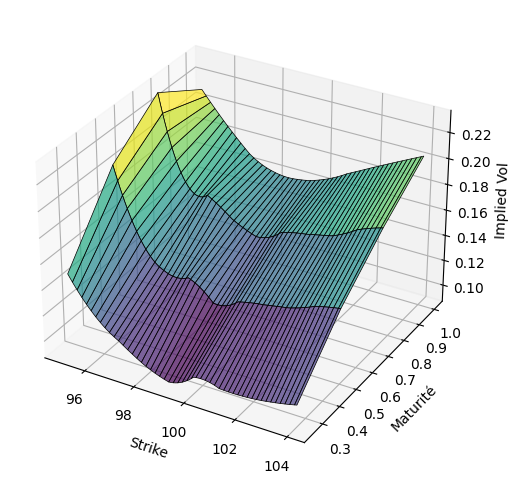

In [487]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Utilisation de plot_surface
ax.plot_surface(df_concatenated['strikes'].values.reshape(4, -1),
                df_concatenated['maturité'].values.reshape(4, -1),
                df_concatenated['implied_vol'].values.reshape(4, -1),
                cmap='viridis', edgecolor='k', linewidth=0.5, alpha=0.7)

# Configurations supplémentaires
ax.set_xlabel('Strike')
ax.set_ylabel('Maturité')
ax.set_zlabel('Implied Vol')

plt.show()

In [489]:
def bilinear_interpolation(x, y, points):
    
# Formule t r o u v e sur https ://fr.wikipedia.org/wiki/Interpolation_bilin%C3%A9aire
    points = sorted(points)
    (x1 , y1 , q11), (_x1 , y2, q12), (x2, _y1 , q21), (_x2 , _y2 , q22) = points

    if x1 != _x1 or x2 != _x2 or y1 != _y1 or y2 != _y2:
        raise ValueError("points do not form a rectangle")
    if not x1 <= x <= x2 or not y1 <= y <= y2:
        raise ValueError("(x, y) not within the rectangle ")

    return (q11 * (x2 - x) * (y2 - y) +
    q21 * (x - x1) * (y2 - y) +
    q12 * (x2 - x) * (y - y1) +
    q22 * (x - x1) * (y - y1)) / ((x2 - x1) * (y2 - y1) + 0.0)


On test l'interpolation bilinéaire avec une valeur que l'on connait pour estimer son erreur

ici avec un Call K=99 T=1

In [490]:
x_val = 99
y_val = 1
z_val = bilinear_interpolation(x_val,y_val,[(98,0.75,float(df_9_months[df_9_months['strikes'] == 98]['implied_vol'].values)),
                                            (98,1,float(df_12_months[df_12_months['strikes'] == 98]['implied_vol'].values)),
                                        (100,0.75,float(df_9_months[df_9_months['strikes'] == 100]['implied_vol'].values)),
                                        (100,1,float(df_12_months[df_12_months['strikes'] == 100]['implied_vol'].values))
                                        ]                 
                               )
z_val

0.16303984649774445

In [491]:
black_scholes_call_price(100,99,1,0,float(df_12_months[df_12_months['strikes']==100]['implied_vol'].values))

7.059195850000883

In [493]:
t1 = black_scholes_call_price(100,99,1,0,float(df_12_months[df_12_months['strikes']==100]['implied_vol'].values))
print(f'Black Scholes Call price with implied vol from dataframe : {t1:.4f}')
t2 = black_scholes_call_price(100,99,1,0,z_val)
print(f'Black Scholes Call price with bilinear interpolated implied vol : {t2:.4f}')

Black Scholes Call price with implied vol from dataframe : 7.0592
Black Scholes Call price with bilinear interpolated implied vol : 6.9769


In [494]:
true_z_val = float(df_12_months[df_12_months['strikes']==100]['implied_vol'].values)
print(f'Implied vol from the dataframe : {true_z_val:.4f}')
print(f'Bilinear interpolated implied vol : {z_val:.4f}')
error = true_z_val - z_val
print(f'The error between bilinear interpolation and true value is : {error:.4f}')

prix_bi = black_scholes_call_price(100,99,1,0,z_val)
print(f"Prix trouvé avec l'interpolation bilinéeaire : {prix_bi:.4f}")
print(f"Prix théorique dans le dataframe: {float(df_concatenated[(df_concatenated['strikes'] == 100) & (df_concatenated['maturité'] == 1)]['prices'].values)}")

Implied vol from the dataframe : 0.1651
Bilinear interpolated implied vol : 0.1630
The error between bilinear interpolation and true value is : 0.0021
Prix trouvé avec l'interpolation bilinéeaire : 6.9769
Prix théorique dans le dataframe: 6.579999996457758


Les prix sont cohérents on l'utilisera donc pour calculer le call K=99.5 T=8/12

In [506]:
x_val = 99.5
y_val = 8/12
z_995_val = bilinear_interpolation(x_val,y_val,[(99,0.75,float(df_9_months[df_9_months['strikes'] == 98]['implied_vol'].values)),
                                        (99,0.5,float(df_6_months[df_6_months['strikes'] == 98]['implied_vol'].values)),
                                        (100,0.75,float(df_9_months[df_9_months['strikes'] == 100]['implied_vol'].values)),
                                        (100,0.5,float(df_6_months[df_6_months['strikes'] == 100]['implied_vol'].values))
                                        ]                 
                               )
z_995_val

0.14458698856348812

La librairie interp2d est ici utilisée comme benchmark

In [505]:
from scipy.interpolate import interp2d
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
strike_prices = list(df_concatenated[df_concatenated['maturité']==1]['strikes'])
maturities = [0.5, 0.75]

implied_volatilities = [
    list(df_6_months['implied_vol'].values),
    list(df_9_months['implied_vol'].values)  
]

interp_func = interp2d(strike_prices, maturities, implied_volatilities, kind='linear')

x_target = 99.5
z_target = 8/12

implied_volatility_8_12 = interp_func(x_target, z_target)

print(f"Implied Volatility for maturity 8/12 and strike 99.5: {implied_volatility_8_12[0]:.4f}")


Implied Volatility for maturity 8/12 and strike 99.5: 0.1371


In [502]:
maturities_original = [0.25, 0.5, 0.75, 1]  # en mois
strikes_original = list(df_concatenated['strikes'])
implied_vol_original = list(df_concatenated['implied_vol'])
 
# Les valeurs à interpoler
maturity_interpolated = 8/12  # en mois
strike_interpolated = 99.50
 
# Appel de la fonction d'interpolation quadratique
x_interpolated = [maturity_interpolated]
x_original = maturities_original
y_original = implied_vol_original
 
y_interpolated = quadratic_interpolation(x_interpolated, x_original, y_original)
 
# Afficher le résultat
print(f"Le prix interpolé pour une option avec strike {strike_interpolated} et maturité {maturity_interpolated:.4f} année est : {y_interpolated[0]:.4f}")

Le prix interpolé pour une option avec strike 99.5 et maturité 0.6667 année est : 0.2074


In [504]:
print(f'Implied vol from interp2d : {implied_volatility_8_12[0]:.4f}')
print(f'Bilinear interpolated implied vol : {z_995_val:.4f}')
error = implied_volatility_8_12[0] - z_995_val
print(f'The error between bilinear interpolation and true value is : {error:.4f}')


prix_quad = black_scholes_call_price(100,99.5,8/12,0,y_interpolated[0])
print(f"Prix trouvé avec l'interpolation quadratique : {prix_quad:.4f}")
prix_bi = black_scholes_call_price(100,99.5,8/12,0,z_995_val)
print(f"Prix trouvé avec l'interpolation bilinéeaire : {prix_bi:.4f}")
prix_interp2d = black_scholes_call_price(100,99.5,8/12,0,implied_volatility_8_12[0])
print(f"Prix théorique dans le dataframe: {prix_interp2d:.4f}")

Implied vol from interp2d : 0.1371
Bilinear interpolated implied vol : 0.1446
The error between bilinear interpolation and true value is : -0.0075
Prix trouvé avec l'interpolation quadratique : 6.9850
Prix trouvé avec l'interpolation bilinéeaire : 4.9494
Prix théorique dans le dataframe: 4.7066
